In [1]:
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib
import brewer2mpl
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.metrics import confusion_matrix

set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
%matplotlib inline
print('successfully loaded all modules')

c:\users\ajaic\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


successfully loaded all modules


In [2]:
validation_split = .2
input_shape = (64, 64, 1)
num_classes = 7

class DataManager(object):
    def __init__(self, dataset_name='fer2013', dataset_path=None, image_size=(48, 48)):

        self.dataset_name = dataset_name
        self.image_size = image_size
        self.dataset_path = 'datasets/fer2013/fer2013.csv'

    def get_data(self):
        data = self._load_fer2013()
        return data
    
    def _load_fer2013(self):
            data = pd.read_csv(self.dataset_path)
            pixels = data['pixels'].tolist()
            width, height = 48, 48
            faces = []
            for pixel_sequence in pixels:
                face = [int(pixel) for pixel in pixel_sequence.split(' ')]
                face = np.asarray(face).reshape(width, height)
                face = cv2.resize(face.astype('uint8'), self.image_size)
                faces.append(face.astype('float32'))
            faces = np.asarray(faces)
            faces = np.expand_dims(faces, -1)
            emotions = pd.get_dummies(data['emotion']).as_matrix()
            return faces, emotions
        
def preprocess_input(x):
    x = x.astype('float32')
    x = x / 255.0
         #- data_format mode=tf: will scale pixels between -1 and 1, sample-wise.
    x = x - 0.5
    x = x * 2.0
    return x
def split_data(x, y, validation_split=.2):
    num_samples = len(x)
    num_train_samples = int((1 - validation_split)*num_samples)
    train_x = x[:num_train_samples]
    train_y = y[:num_train_samples]
    val_x = x[num_train_samples:]
    val_y = y[num_train_samples:]
    train_data = (train_x, train_y)
    val_data = (val_x, val_y)
    return train_data, val_data


    
emotion_model_path = 'training_output/fer2013_mini_XCEPTION.94-0.66.hdf5'
#emotion_model_path = 'training_output/exp2.68-0.66.hdf5'
model = load_model(emotion_model_path, compile=True)
#emotion labels
labels=['angry','disgust','fear','happy','sad','surprise','neutral']

print("Model Loaded")
data_loader = DataManager(dataset_name='fer2013', image_size=input_shape[:2])
faces, emotions = data_loader.get_data()
print("Data retrieved from fer2013")
faces = preprocess_input(faces)
num_samples, num_classes = emotions.shape
train_data, val_data = split_data(faces, emotions, validation_split)
print("data split to train and test data")
train_faces, train_emotions = train_data
val_faces,val_emotions = val_data


Model Loaded
Data retrieved from fer2013
data split to train and test data


In [3]:
#Show Sample Faces --Not  Working
def overview(start, end, X):
    fig = plt.figure(figsize=(10,10))
    print (X[0:1,:])
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(input_img[0,0,:,:], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

In [4]:
#overview(0,10, val_faces) # overview of face data as thumbnails (train)

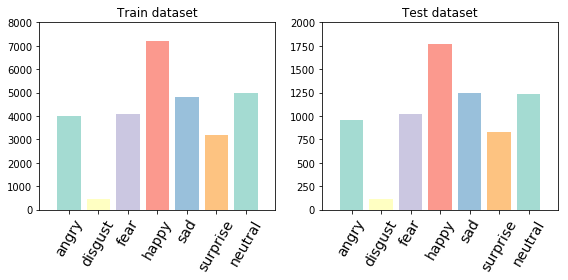

In [5]:
y_train_labels  = [np.argmax(lst) for lst in train_emotions]
y_public_labels = [np.argmax(lst) for lst in val_emotions]

#Dataset Distribution
def plot_distribution(y1, y2, data_names, ylims =[1000,1000]): 
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.bar(np.arange(1,8), np.bincount(y1), color=set3, alpha=0.8)
    ax1.set_xticks(np.arange(1,7.25,1))
    ax1.set_xticklabels(labels, rotation=60, fontsize=14)
    ax1.set_xlim([0, 8])
    ax1.set_ylim([0, ylims[0]])
    ax1.set_title(data_names[0])
    ax2 = fig.add_subplot(1,2,2)
    ax2.bar(np.arange(1,8), np.bincount(y2), color=set3, alpha=0.8)
    ax2.set_xticks(np.arange(1,7.24,1))
    ax2.set_xticklabels(labels, rotation=60, fontsize=14)
    ax2.set_xlim([0, 8])
    ax2.set_ylim([0, ylims[1]])
    ax2.set_title(data_names[1])
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_train_labels, y_public_labels, ['Train dataset', 'Test dataset'], ylims =[8000,2000]) 

In [6]:
#Overall Training Evaluation
train_score = model.evaluate(train_faces, train_emotions, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])

test_score = model.evaluate(val_faces, val_emotions, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.7358682380727791
Train accuracy: 73.3010554185768
Test loss: 0.9507416242774598
Test accuracy: 65.53357481192533


In [7]:
# prediction and true labels
y_prob = model.predict(val_faces, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in val_emotions]

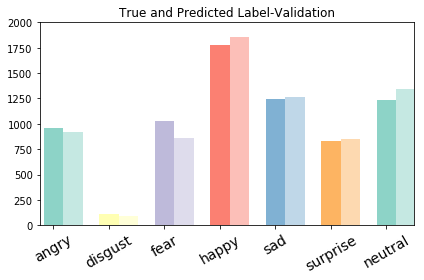

In [8]:
def plot_distribution(y_true, y_pred):
    ind = np.arange(1.5,8,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color=set3, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=set3, alpha=0.5)
    ax.set_xticks(np.arange(1.5,8,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 8])
    ax.set_ylim([0, 2000])
    ax.set_title('True and Predicted Label-Validation')
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_true, y_pred)

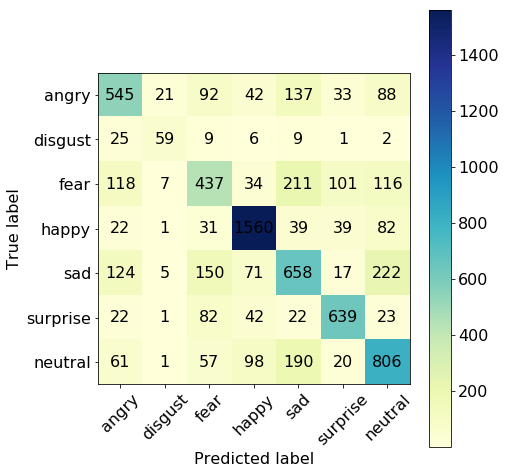

In [9]:
#Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(7,7))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)

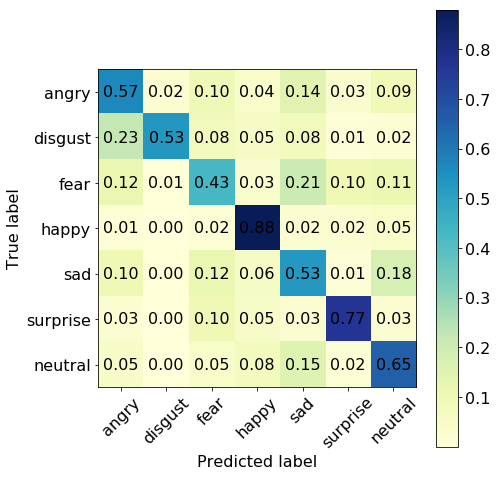

In [10]:
#Normalised Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #Normalisation Happens here
    fig = plt.figure(figsize=(7,7))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,format(cm[i, j], '.2f'),va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)

In [11]:
def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(0,7)]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(0,7)]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,7) if j != i])
    fp = sum([cm[j,i] for j in range(0,7) if j != i])
    tn = sum([cm[i,j] for j in range(0,7) for i in range(0,7)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

# Accuracy, Precision, Recall
for emotion in labels:
    print (emotion.upper())
    print ('   acc = {}'.format(class_accuracy(y_true, y_pred, emotion)))
    print ('  prec = {}'.format(class_precision(y_true, y_pred, emotion)))
    print ('recall = {}\n'.format(class_recall(y_true, y_pred, emotion)))

ANGRY
   acc = 0.8906380607411535
  prec = 0.5943293347873501
recall = 0.5688935281837161

DISGUST
   acc = 0.9877403176372248
  prec = 0.6210526315789474
recall = 0.5315315315315315

FEAR
   acc = 0.8595709111173029
  prec = 0.5093240093240093
recall = 0.4267578125

HAPPY
   acc = 0.9293675118417386
  prec = 0.8418780356179169
recall = 0.8793686583990981

SAD
   acc = 0.8332404569517972
  prec = 0.5197472353870458
recall = 0.5276663993584603

SURPRISE
   acc = 0.943856227361382
  prec = 0.7517647058823529
recall = 0.7689530685920578

NEUTRAL
   acc = 0.8662580105879075
  prec = 0.6019417475728155
recall = 0.6536901865369019



In [12]:
from sklearn.metrics import classification_report
print (classification_report(y_true, y_pred, target_names=labels))

             precision    recall  f1-score   support

      angry       0.59      0.57      0.58       958
    disgust       0.62      0.53      0.57       111
       fear       0.51      0.43      0.46      1024
      happy       0.84      0.88      0.86      1774
        sad       0.52      0.53      0.52      1247
   surprise       0.75      0.77      0.76       831
    neutral       0.60      0.65      0.63      1233

avg / total       0.65      0.66      0.65      7178



In [13]:
from sklearn.metrics import hamming_loss
hamming_loss(y_true, y_pred)

0.34466425188074673

In [14]:
#MisClassification Rate
n = len(y_true)
y_fir = []
y_sec = []
y_trd = []
for i in range(n):
    if y_true[i] == np.argsort(y_prob[i])[-1]:
        y_fir.append([i, y_true[i]])
    if y_true[i] == np.argsort(y_prob[i])[-2]:
        y_sec.append([i, y_true[i]])
    if y_true[i] == np.argsort(y_prob[i])[-3]:
        y_trd.append([i, y_true[i]])
print (float(len(y_fir))/n)
print (float(len(y_sec))/n)
print (float(len(y_trd))/n)

misclass = [float(len(y_fir))/n, float(len(y_sec))/n, float(len(y_trd))/n]

0.6553357481192533
0.1779047088325439
0.08539983282251323


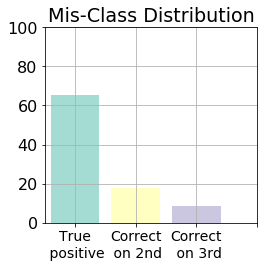

[0.6553357481192533, 0.1779047088325439, 0.08539983282251323]


In [15]:
def plot_misclass_distribution(y, tags): 
    fig = plt.figure(figsize=(4,4))
    ax1 = fig.add_subplot(1,1,1)
    ax1.bar(np.arange(1,len(y)+1), np.array(y)*100, color=set3, alpha=0.8)
    ax1.set_xticks(np.arange(1,len(y)+1.40,1))
    ax1.set_xticklabels(tags, rotation=0, fontsize=14)
    ax1.set_xlim([0.5, len(y)+1])
    ax1.set_ylim([0,100])
    ax1.grid(True)
    ax1.set_title('Mis-Class Distribution')
    plt.tight_layout()
    plt.show()
tags = ['True\n positive','Correct\n on 2nd','Correct\n on 3rd']
plot_misclass_distribution(misclass, tags)
print(misclass)

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 62, 62, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 62, 62, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 62, 62, 8)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [17]:
#print(model.layers[1].output)

In [18]:
#Show Filters -- Working for conv2d layers (1 and 4,12,21,30,39)
def plot_2dconvfilters(layer, x, y):
    filters = layer.get_weights()
    print(layer.output)
    #print(filters[0][0])
    
    fig = plt.figure(figsize=(8, 4))
    print("Len of FIlters:" +str(len(filters)))
    plCount=1;
    for i in range(len(filters)):
        print("Len of 1 Filter:"+str(len(filters[i])))
        for j in range(len(filters[i])):
            print(len(filters[i][j]))
            for k in range(len(filters[i][j])):
                ax = fig.add_subplot(y, x, plCount)
                plCount=plCount+1;
                ax.matshow(filters[i][j][k], cmap = matplotlib.cm.Blues)
                plt.xticks(np.array([]))
                plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

#plot_2dconvfilters(model.layers[39], 3, 3)

In [19]:
#Show Filters -- Working for batchorm layers (8)
def plot_batchnormfilters(layer, x, y):
    filters = layer.get_weights()
    print(layer.output)
    #print(filters[0][0])
    
    fig = plt.figure(figsize=(8, 4))
    print("Len of FIlters:" +str(len(filters)))
    plCount=1;
    ax = fig.add_subplot(y, x, plCount)
    plCount=plCount+1;
    ax.matshow(filters, cmap = matplotlib.cm.Blues)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

#plot_batchnormfilters(model.layers[8], 1, 4)

In [20]:
#Show Filters -- Working for seperable conv2d layers (7,10,16,25,34)
def plot_sepconvfilters(layer, x, y):
    filters = layer.get_weights()
    print(layer.output)
    #print(filters[0][0])
    
    fig = plt.figure(figsize=(8, 4))
    print("Num of FIlters:" +str(len(filters)))
    plCount=1;
    for i in range(len(filters)):
        print("Len of Filter:"+str(len(filters[i])))
        for j in range(len(filters[i])):
            print(len(filters[i][j]))
            for k in range(len(filters[i][j])):
                ax = fig.add_subplot(y, x, plCount)
                plCount=plCount+1;
                ax.matshow(filters[i][j][k], cmap = matplotlib.cm.Blues)
                plt.xticks(np.array([]))
                plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

#plot_sepconvfilters(model.layers[34], 3, 4)

In [21]:
 #print(model.layers[43].output)

In [22]:
#Show Filters -- Working for conv2d layers (1 and 4,12,21,30,39)
def plot_convfilters(layer, x, y):
    filters = layer.get_weights()
    print(layer.output)
    #print(filters[0][0])
    
    fig = plt.figure(figsize=(8, 4))
    print("Len of FIlters:" +str(len(filters)))
    plCount=1;
    for i in range(len(filters)):
        print("Len of 1 Filter:"+str(len(filters[i])))
        for j in range(len(filters[i])):
            #print(len(filters[i][j]))
            for k in range(len(filters[i][0])):
                ax = fig.add_subplot(y, x, plCount)
                plCount=plCount+1;
                ax.matshow(filters[i][0][k], cmap = matplotlib.cm.Blues)
                plt.xticks(np.array([]))
                plt.yticks(np.array([]))
            ax = fig.add_subplot(y, x, plCount)
            plCount=plCount+1;
            ax.matshow(filters[i][1], cmap = matplotlib.cm.Blues)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

#plot_convfilters(model.layers[43], 3, 3)

In [23]:
#print(len(model.layers))